In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [4]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [5]:
min(mauna_loa['norm_y']), max(mauna_loa['norm_y']), min(mauna_loa['norm_day']), max(mauna_loa['norm_day'])

(0.0, 1.0, 0.0, 1.0)

In [6]:
2 * np.pi / (365.25 / day_range)

374.4967669741262

In [7]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

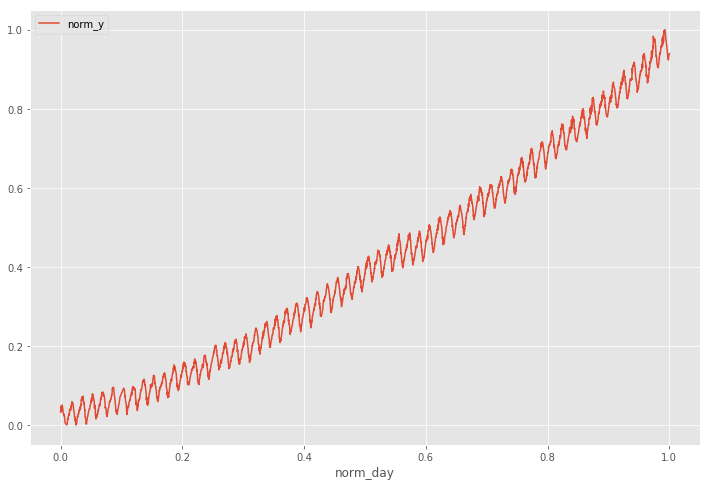

In [8]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

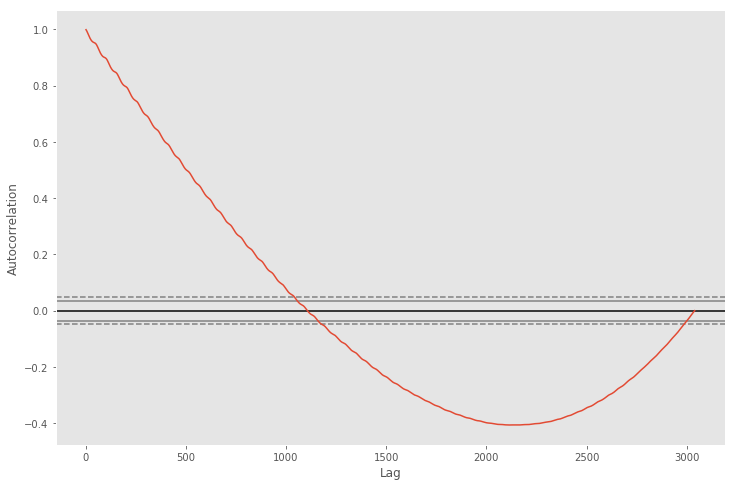

In [9]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

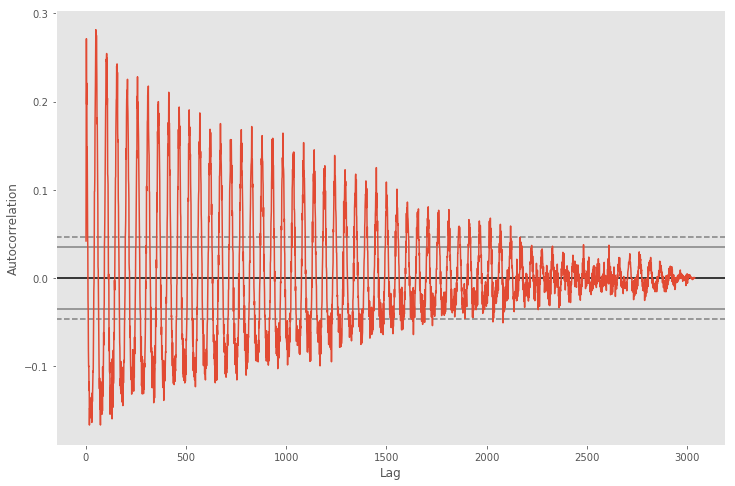

In [10]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

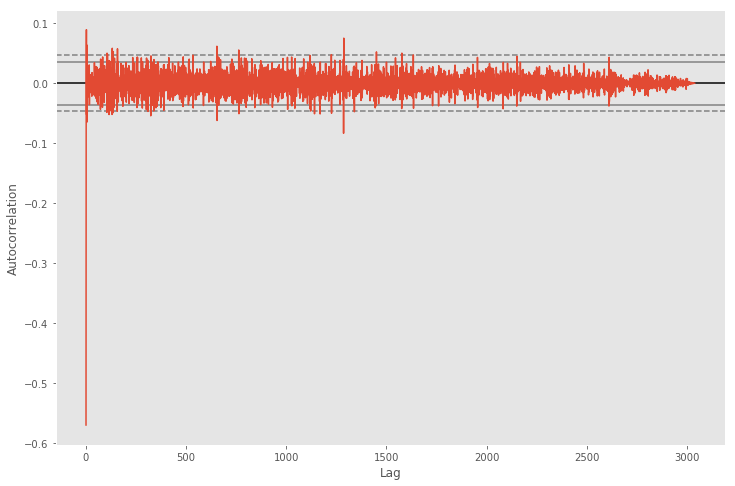

In [11]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

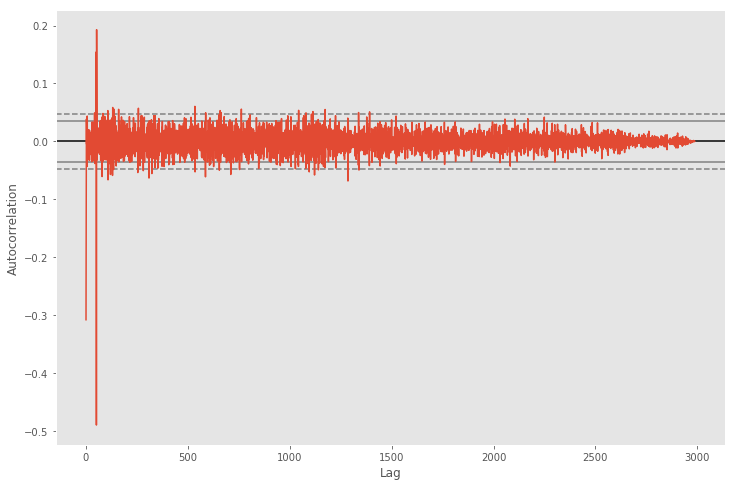

In [12]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

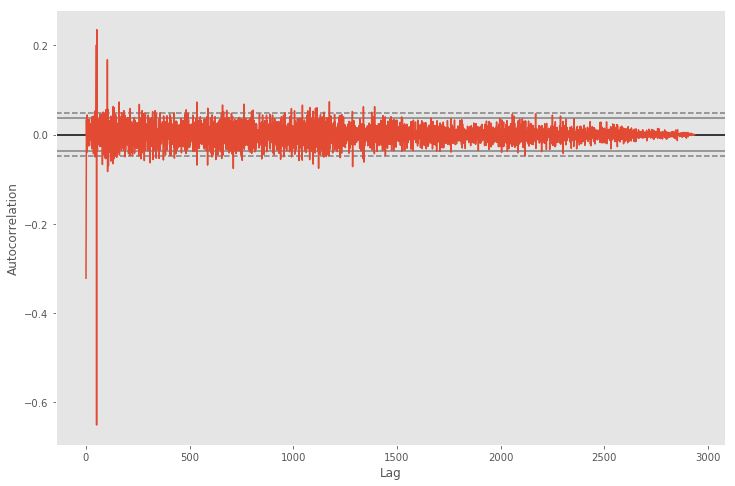

In [13]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

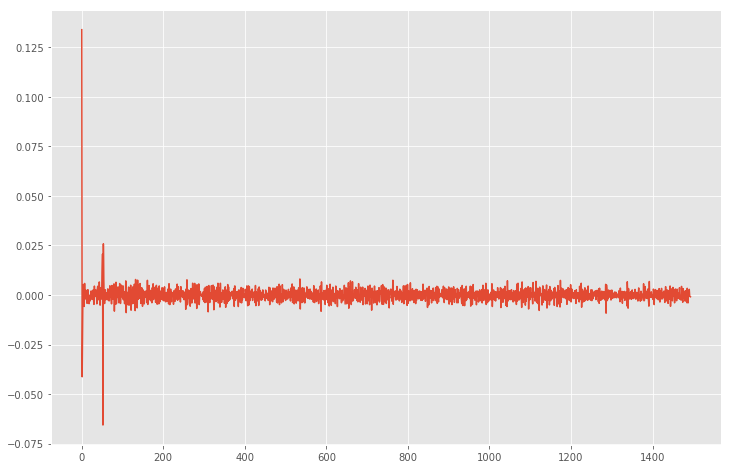

In [14]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [15]:
np.argmax(half_corr[1:])

52

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


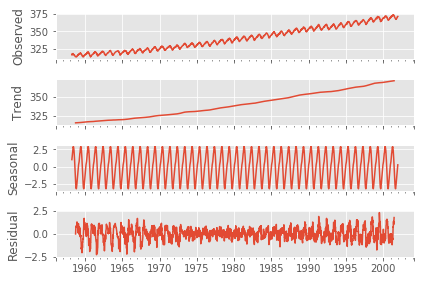

In [16]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

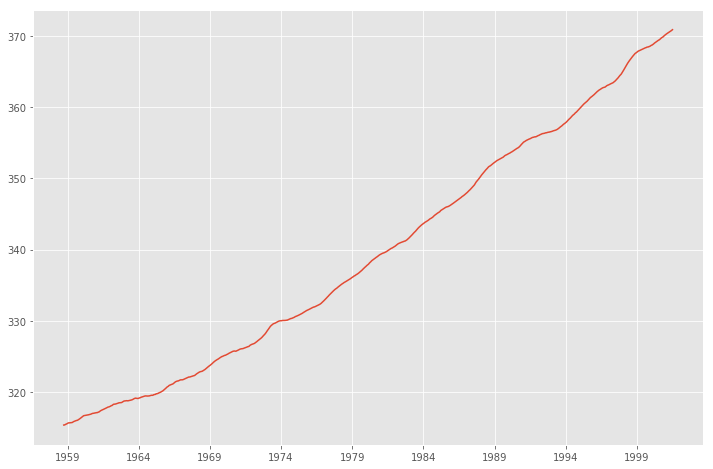

In [17]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

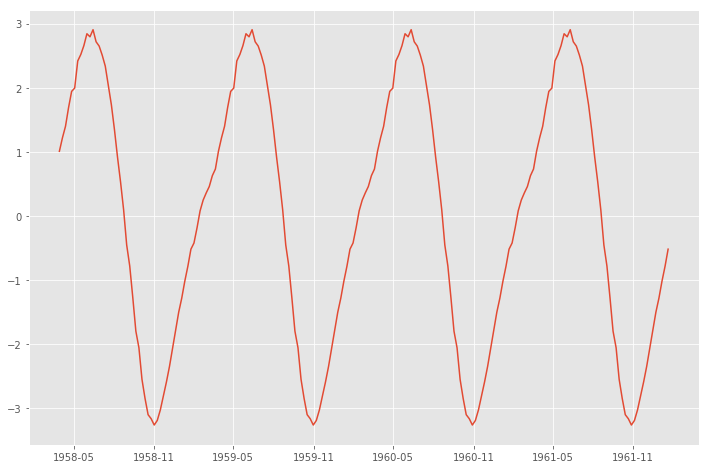

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[:200])

In [19]:
def assymetric_triangle_wave(alpha, omega, phi, min_point, x_values):
    x_values = np.asarray(x_values)
    y_values = []
    x_mod = (x_values * omega + phi) % (2 * np.pi)
    
    for x in x_mod:
        if x < min_point:
            y_values.append(1 - 2 * x / min_point)
        else:
            y_values.append((2*x  - min_point - 2 * np.pi) / (2 * np.pi - min_point))
            
    return np.asarray(y_values) * alpha
    

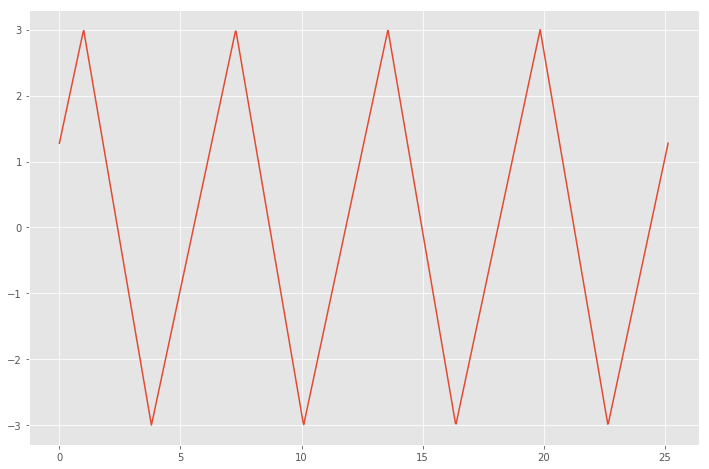

In [20]:
x_tri = np.linspace(0, 8 * np.pi, 1000)
y_tri = assymetric_triangle_wave(3, 1, -1, 2.8, x_tri)

plt.figure(figsize=(12, 8))
plt.plot(x_tri, y_tri)


In [21]:
import pickle

samples = None
with open('model_samples.pickle', 'rb') as out_file_1:
    samples = pickle.load(out_file_1)
    
positive_tri_samples = None
with open('positive_tri_samples_2.pickle', 'rb') as out_file_2:
    positive_tri_samples = pickle.load(out_file_2)
    
positive_tri_long_sin_samples = None
with open('positive_tri_long_sin_samples.pickle', 'rb') as out_file_3:
    positive_tri_long_sin_samples = pickle.load(out_file_3)
    
samples.keys(), positive_tri_samples.keys(), positive_tri_long_sin_samples.keys()

(odict_keys(['b', 'unbound_omega', 'phi_x', 'phi_y', 'unbound_alpha', 'unbound_sigma_y', 'phi', 'alpha', 'sigma_y', 'y_simulated_train', 'y_future', 'lp__']),
 odict_keys(['b', 'unbound_omega', 'phi_x', 'phi_y', 'unbound_alpha', 'sigma_y', 'min_point_x', 'min_point_y', 'phi', 'alpha', 'min_point', 'positive_b', 'y_simulated_train', 'y_future', 'lp__']),
 odict_keys(['sigma_y', 'b', 'unbound_omega', 'phi_x', 'phi_y', 'unbound_alpha', 'min_point_x', 'min_point_y', 'long_term_unbound_omega', 'long_term_phi_x', 'long_term_phi_y', 'long_term_unbound_alpha', 'phi', 'alpha', 'min_point', 'positive_b', 'long_term_phi', 'long_term_alpha', 'y_simulated_train', 'y_future', 'lp__']))

In [22]:
# TRAIN_SIZE = 1040
# TEST_SIZE = 1040
# train = mauna_loa[:TRAIN_SIZE]
# test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

TEST_SIZE = 0.25
N = len(mauna_loa)

train = mauna_loa[:int(-N * TEST_SIZE)]
test = mauna_loa[int(-N * TEST_SIZE):]
len(mauna_loa), len(train), len(test)

(3040, 2280, 760)

In [23]:
residuals = samples['y_simulated_train'] - train['norm_y'].as_matrix()
positive_tri_residuals_train = positive_tri_samples['y_simulated_train'] - train['norm_y'].as_matrix()
positive_tri_residuals_test = positive_tri_samples['y_future'] - test['norm_y'].as_matrix()
positive_tri_long_sin_residuals_train = positive_tri_long_sin_samples['y_simulated_train'] - train['norm_y'].as_matrix()
positive_tri_long_sin_residuals_test = positive_tri_long_sin_samples['y_future'] - test['norm_y'].as_matrix()

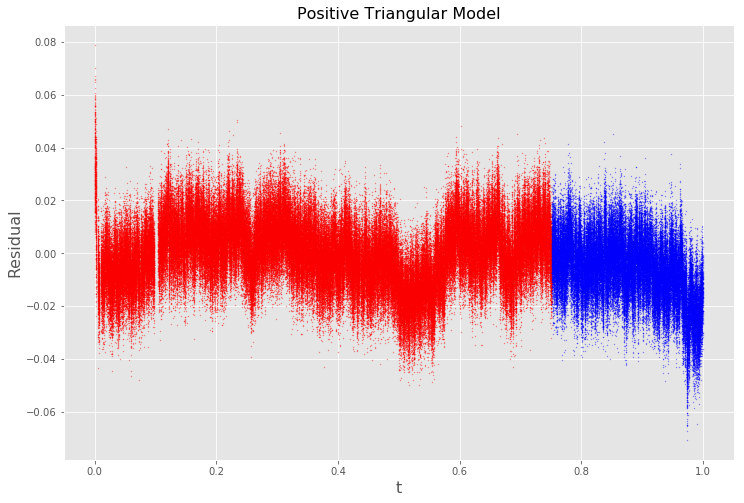

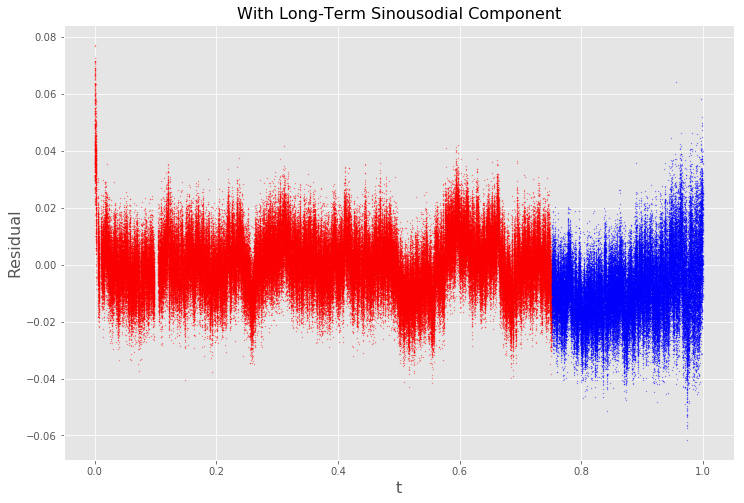

In [24]:
plt.figure(figsize=(12, 8))

t_train = train['norm_day'].as_matrix()
t_test = test['norm_day'].as_matrix()

def residual_scatter_plot(x_train, res_train, x_test=None, res_test=None, title=None, count=100):
    plt.figure(figsize=(12, 8))
    indices = np.random.choice(range(res_train.shape[0]), count, False)
    for i in indices:
        plt.scatter(x_train, res_train[i], alpha=0.3, s=1, color='red')
        
    if x_test is not None and res_test is not None:
        test_indices = np.random.choice(range(res_test.shape[0]), count, False)
        for i in test_indices:
            plt.scatter(x_test, res_test[i], alpha=0.3, s=1, color='blue')
            
    plt.xlabel('t', fontsize=16)
    plt.ylabel('Residual', fontsize=16)
    if title is not None:
        plt.title(title, fontsize=16)
        
    plt.show()

    
residual_scatter_plot(t_train, positive_tri_residuals_train, 
                     t_test, positive_tri_residuals_test, 'Positive Triangular Model')
residual_scatter_plot(t_train, positive_tri_long_sin_residuals_train, 
                     t_test, positive_tri_long_sin_residuals_test, 'With Long-Term Sinousodial Component')
    
# for x, y in zip((t_train, t_train, t_test, t_train, t_test),
#                 (residuals, positive_tri_residuals_train, positive_tri_residuals_test, 
#                  positive_tri_long_sin_residuals_train, positive_tri_long_sin_residuals_test)): 
#     plt.figure(figsize=(12, 8))
#     for y_index in range(100):
#         plt.scatter(x, y[1000 + y_index], alpha=0.3, s=1)
    
#     plt.show()


In [25]:
def stat_and_test_histograms(data, stat_func, test_func, name, color=None):
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 3, hspace=0.7)
    
    s = stat_func(residuals)
    z, p = test_func(residuals)

    left_ax = plt.subplot(gs[0, 0])
    left_ax.hist(s, color=color)
    left_ax.set_xlabel(name)
    left_ax.set_ylabel('Frequency')
    plt.title(name + ' statistic')

    middle_ax = plt.subplot(gs[0, 1])
    middle_ax.hist(z, color=color)
    middle_ax.set_xlabel('Z-scores')
    middle_ax.set_ylabel('Frequency')
    plt.title(name + ' Z-scores')
    
    right_ax = plt.subplot(gs[0, 2])
    right_ax.hist(p, color=color)
    right_ax.set_xlabel('P-values')
    right_ax.set_ylabel('Frequency')
    plt.title(name + ' P-values')

    plt.show()

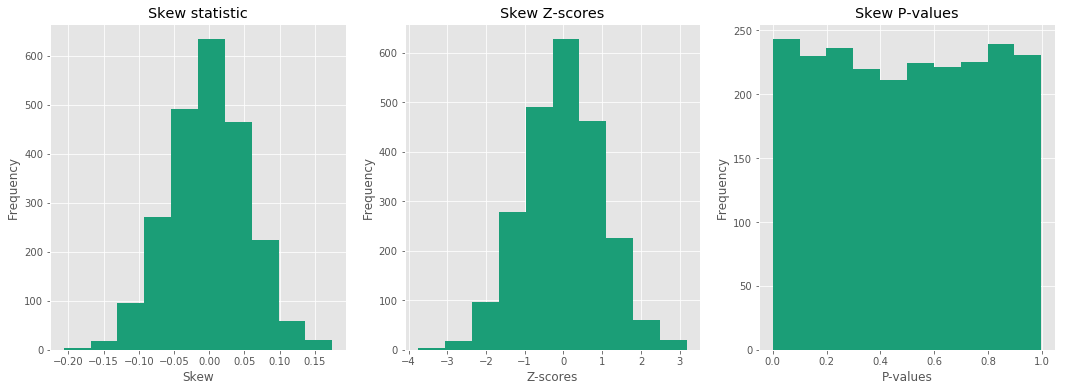

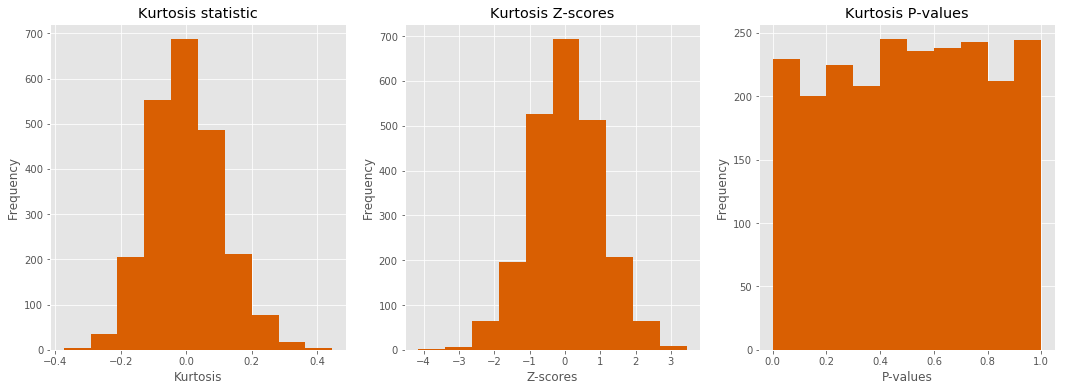

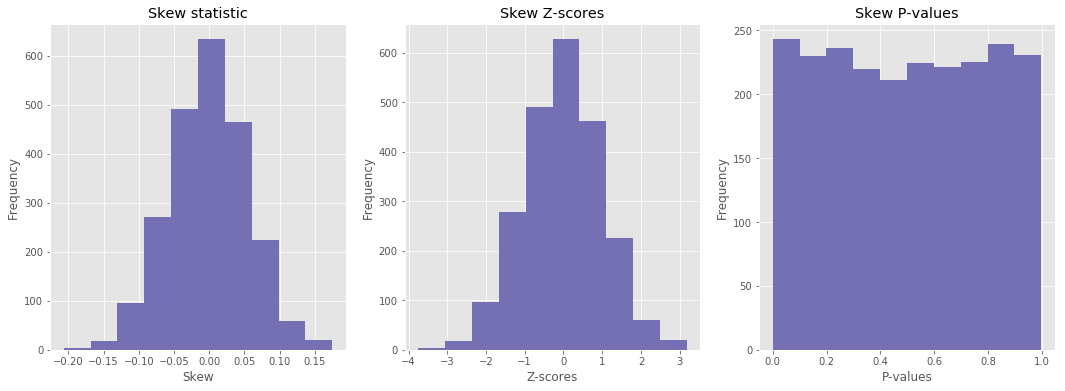

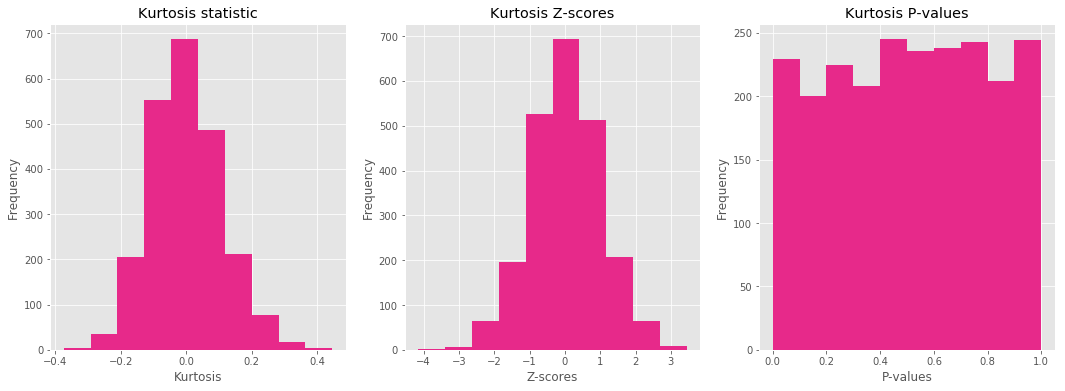

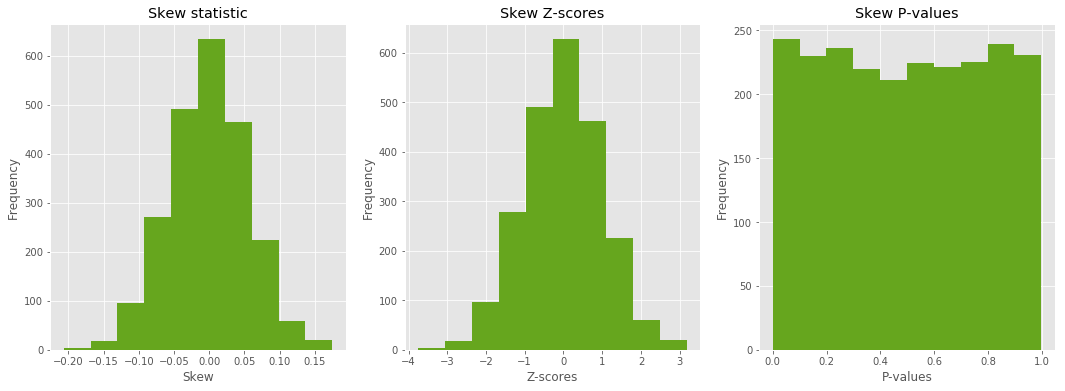

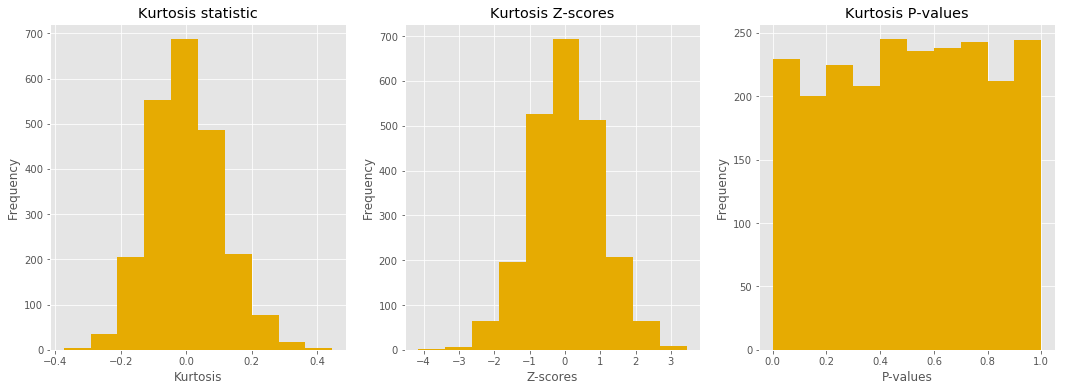

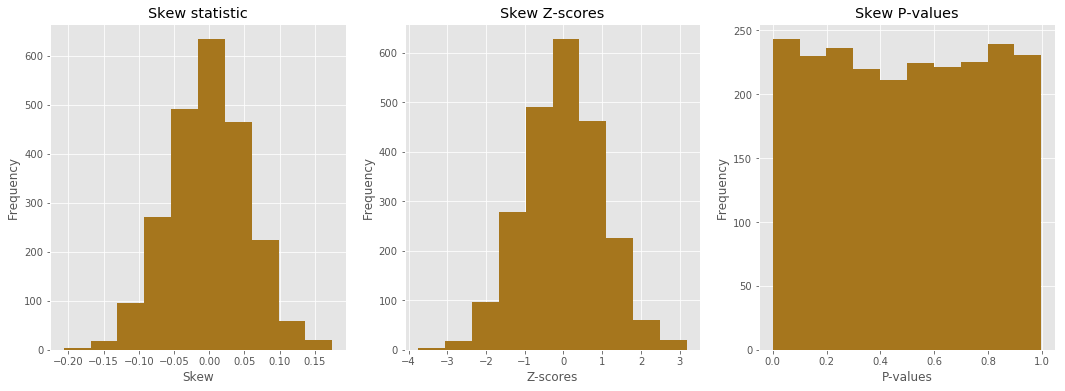

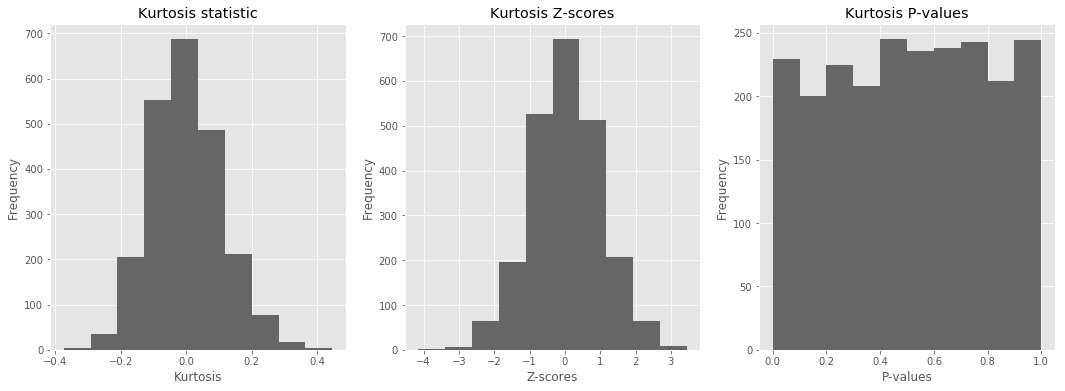

In [26]:
from matplotlib import cm
from scipy import stats

for i, res in enumerate((positive_tri_residuals_train, positive_tri_residuals_test, 
                 positive_tri_long_sin_residuals_train, positive_tri_long_sin_residuals_test)):
    stat_and_test_histograms(res, stats.skew, stats.skewtest, 'Skew', cm.Dark2.colors[2 * i])
    stat_and_test_histograms(res, stats.kurtosis, stats.kurtosistest, 'Kurtosis', cm.Dark2.colors[2 * i + 1])


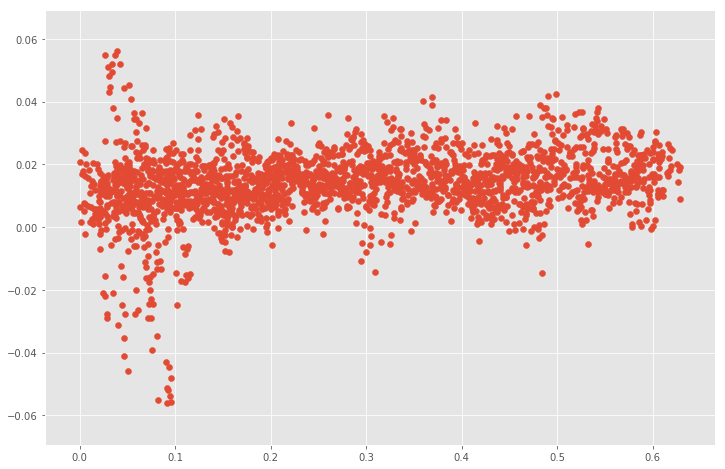

In [27]:
norm_y =  train['norm_y'].as_matrix()
diff = [y - x for x, y in zip(norm_y, norm_y[52:])]


plt.figure(figsize=(12, 8))
plt.scatter(norm_y[:-52], diff)
plt.show()

In [ ]:
ys1 = samples['y_simulated_train'][0]
diff_ys1 = [y - x for x, y in zip(ys1, ys1[52:])]


plt.figure(figsize=(12, 8))
plt.scatter(ys1[:-52], diff_ys1)
plt.show()

In [ ]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

from sklearn.linear_model import Ridge, LassoLarsIC, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.asarray(train['norm_day']).reshape(-1, 1)
y = np.asarray(train['norm_y'])

X_train = X[:-200]
y_train = y[:-200]
X_test = X[-200:]
y_test = y[-200:]

fig = plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train, color='black')
plt.plot(X_test, y_test, color='red')

for count, degree in enumerate(range(1, 8)):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # LassoLarsIC(criterion='bic'))
    model.fit(X_train, y_train)
#     ic = np.sum(model.steps[1][1].criterion_)
    y_plot = model.predict(X)
    plt.plot(X, y_plot, lw=4, alpha=0.75,
             label='{d} degree, $R^2 = {r2:.4f}$'.format(d=degree, r2=model.score(X_test, y_test)))
#             label='{d} degree, $R^2 = {r2:.4f}$, ic = {ic:.3e}'.format(
#                 d=degree, r2=model.score(X_test, y_test), ic=ic))

plt.legend(loc=2, fontsize=12)

In [ ]:
np.random.poisson(2, 10) + 1

In [42]:
t_values = mauna_loa['norm_day'].as_matrix()
t_step = t_values[-1] - t_values[-2]
t_fourty_years = np.asarray(list(t_values[-1] + t_step * i * 7 for i in range(int(40 * 362.25 / 7))))

In [45]:
t_fourty_years.shape[0] / 52

39.80769230769231